# Beispiel-Code Einführungsvorlesung

Zuerst installieren wir die notwendigen python Pakete mit Pip (falls noch nicht geschehen)

In [1]:
!pip install --user -r requirements.txt

You should consider upgrading via the '/opt/tljh/user/bin/python3.9 -m pip install --upgrade pip' command.


Wir importieren notwendige Pakete sowie Hilfsfunktionen, welche für den Wettbewerb bereitgestellt werden

In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from wettbewerb import load_references, get_3montages
import mne
from scipy import signal as sig
import ruptures as rpt

Der Ordner mit den Trainingsdaten liegt in unserem Fall in einem Ordner eine Ebene über dem git-Repository. Wir laden für dieses Beispiel nur ein kleines Subset der Trainingsdaten.

In [3]:
training_folder = "../../shared_data/training_mini"

Importiere EEG-Dateien bestehend aus Name (id), Kanalbezeichnung (channels), Sampling-Frequenz (Hz), Referenzsystem und zugehörige Diagnose (seizure_present,onset,offset).  (meist fs=256 Hz)

In [4]:
ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(training_folder) 



100	 Dateien wurden geladen.


In [5]:
idx_record = 80
print("IDs[0:3]: ",ids[:3])
print("Verfügbare Kanäle:",channels[idx_record])
print("Abtastrate: ", sampling_frequencies[idx_record],"Hz")
print("Referenzsystem: ", reference_systems[idx_record])
print("EEG Labels: (seizure_present, onset, offset)", eeg_labels[idx_record])

IDs[0:3]:  ['aaaaaaac_s001_t000', 'aaaaaaac_s001_t001', 'aaaaaaac_s002_t000']
Verfügbare Kanäle: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
Abtastrate:  250 Hz
Referenzsystem:  LE
EEG Labels: (seizure_present, onset, offset) (1, 18.096, 31.6404)


In [6]:
# Berechne Montagen der linken und rechten Gehirnhälfte für die erste Aufnahme
new_montage, new_data, is_missing = get_3montages(channels[idx_record], data[idx_record])
print("Alle Montagen wurden berechnet: ", not is_missing)
print("Montagen: ",new_montage)
print("Signal Dimension: ", new_data.shape)

Alle Montagen wurden berechnet:  True
Montagen:  ['Fp1-F3', 'Fp2-F4', 'C3-P3']
Signal Dimension:  (3, 199726)


Wir schauen die drei Montagen an

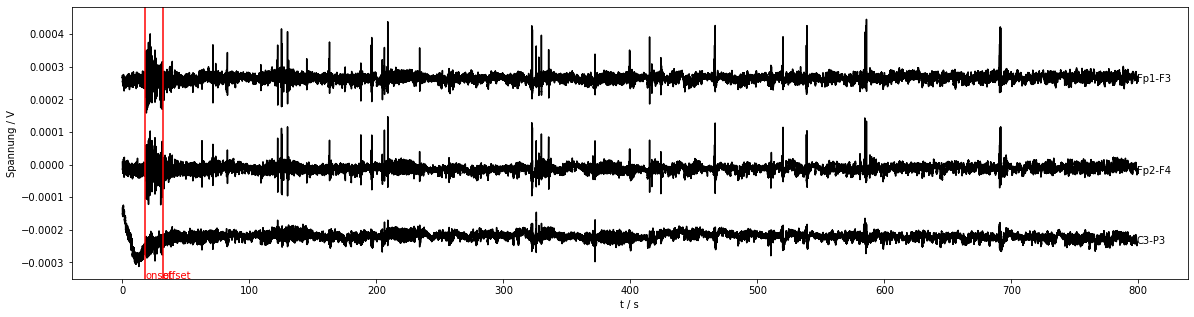

In [7]:
fig, axs = plt.subplots(figsize=[20,5])
max_diff=new_data.max()-new_data.min()
time_ax = np.arange(new_data.shape[1])/sampling_frequencies[idx_record]
_off_sets = [max_diff/1.5,0,-max_diff/1.5]
_labels = eeg_labels[idx_record]

for i, _montage in enumerate(new_montage):
    plt.plot(time_ax,new_data[i,:]+_off_sets[i],'k')
    plt.text(time_ax[-1], new_data[i,-1]+_off_sets[i], _montage)
if _labels[0]:
    plt.axvline(x = _labels[1], color = 'r', label = 'onset')
    plt.text(_labels[1], axs.get_ylim()[0], 'onset',color='r')  
    plt.axvline(x = _labels[2], color = 'r', label = 'offset')
    plt.text(_labels[2], axs.get_ylim()[0], 'offset',color='r')   
plt.xlabel("t / s")
plt.ylabel("Spannung / V")
plt.show()

## Bestimmung des Onsets des Anfalls
Das zentrale Ziel des Wettbewerbs ist die Bestimmung des Onsets des Anfalls. Dieser wird im folgenden ohne Machine-Learning sondern auf Basis einfacher Überlegungen und Signalverarbeitung bestimmt. Man kann damit in einigen Fällen bereits sehr gute Ergebnisse erzielen, allerdings gibt es auch einge Fälle in denen dies nicht funktioniert. Das zu lösen ist eure Aufgabe im Verlaufe des Wettbewerbs.

In [13]:
onset_list_predict = []
onset_list = []
seizure_id_list = []

for i,_id in enumerate(ids):
    _fs = sampling_frequencies[i]
    _eeg_signals = data[i]
    _eeg_label = eeg_labels[i]
    if _eeg_label[0]:
        onset_list.append(_eeg_label[1])
        seizure_id_list.append(_id)
        # Berechne Montage
        _montage, _montage_data, _is_missing = get_3montages(channels[i], _eeg_signals)
        for j, signal_name in enumerate(_montage):
            # Ziehe erste Montage des EEG
            signal = _montage_data[j]
            # Wende Notch-Filter an um Netzfrequenz zu dämpfen
            signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
            # Wende Bandpassfilter zwischen 0.5Hz und 70Hz um Rauschen aus dem Signal zu filtern
            signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
            
            # Berechne short time fourier transformation des Signal: signal_filtered = filtered signal of channel, fs = sampling frequency, nperseg = length of each segment
            # Output f= array of sample frequencies, t = array of segment times, Zxx = STFT of signal
            f, t, Zxx = sig.stft(signal_filter, _fs, nperseg=_fs * 3)
            # Berechne Schrittweite der Frequenz
            df = f[1] - f[0]
            # Berechne Engergie (Betrag) basierend auf Real- und Imaginärteil der STFT
            E_Zxx = np.sum(Zxx.real ** 2 + Zxx.imag ** 2, axis=0) * df

            # Erstelle neues Array in der ersten Iteration pro Patient
            if j == 0:
                # Initilisiere Array mit Energiesignal des ersten Kanals
                E_array = np.array(E_Zxx)
            else:
                # Füge neues Energiesignal zu vorhandenen Kanälen hinzu (stack it)
                E_array = np.vstack((E_array, np.array(E_Zxx)))

        # Berechne Gesamtenergie aller Kanäle für jeden Zeitpunkt
        E_total = np.sum(E_array, axis=0)
        # Berechne Stelle der maximalen Energie
        max_index = E_total.argmax()

        # Berechne "changepoints" der Gesamtenergie
        # Falls Maximum am Anfang des Signals ist muss der Onset ebenfalls am Anfang sein und wir können keinen "changepoint" berechnen
        if max_index == 0:
            onset_list_predict.append(0.0)
        else:
            # Berechne "changepoint" mit dem ruptures package
            # Setup für  "linearly penalized segmentation method" zur Detektion von changepoints im Signal mi rbf cost function
            algo = rpt.Pelt(model="rbf").fit(E_total)
            # Berechne sortierte Liste der changepoints, pen = penalty value
            result = algo.predict(pen=10)
            #Indices sind ums 1 geshiftet
            result1 = np.asarray(result) - 1
            # Selektiere changepoints vor Maximum
            result_red = result1[result1 < max_index]
            # Falls es mindestens einen changepoint gibt nehmen wir den nächsten zum Maximum
            if len(result_red)<1:
                # Falls keine changepoint gefunden wurde raten wir, dass er "nahe" am Maximum ist
                print('No changepoint, taking maximum')
                onset_index = max_index
            else:
                # Der changepoint entspricht gerade dem Onset 
                onset_index = result_red[-1]
            # Füge Onset zur Liste der Onsets hinzu
            onset_list_predict.append(t[onset_index])

No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum


Wir schauen das Ergebnis auf Basis der Montagen an

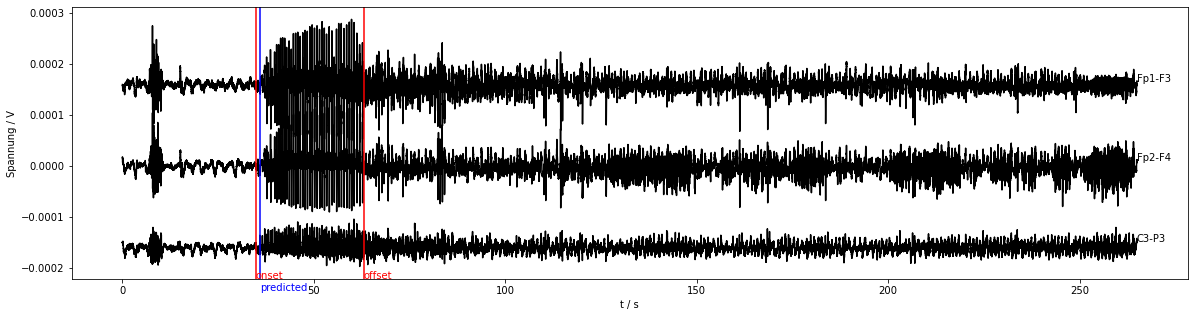

In [14]:
fig,axs = plt.subplots(figsize=[20,5])
max_diff=new_data.max()-new_data.min()
time_ax = np.arange(new_data.shape[1])/sampling_frequencies[idx_record]
_off_sets = [max_diff/1.5,0,-max_diff/1.5]
_labels = eeg_labels[idx_record]

for i, _montage in enumerate(new_montage):
    plt.plot(time_ax,new_data[i,:]+_off_sets[i],'k')
    plt.text(time_ax[-1], new_data[i,-1]+_off_sets[i], _montage)
if _labels[0]:
    pred_idx = seizure_id_list.index(ids[idx_record])
    plt.axvline(x = _labels[1], color = 'r', label = 'onset')
    plt.text(_labels[1], axs.get_ylim()[0], 'onset',color='r')  
    plt.axvline(x = _labels[2], color = 'r', label = 'offset')
    plt.text(_labels[2], axs.get_ylim()[0], 'offset',color='r')  
    plt.axvline(x = onset_list_predict[pred_idx], color = 'b', label = 'onset') 
    plt.text(onset_list_predict[pred_idx], axs.get_ylim()[0]-max_diff/10, 'predicted',color='b') 
plt.xlabel("t / s")
plt.ylabel("Spannung / V")
plt.show()

Zur Verifikation berechnen wir den absoluten Fehler zwischen dem detektierten Seizure Onset und der ground truth basierend auf den Annotationen der Ärzte

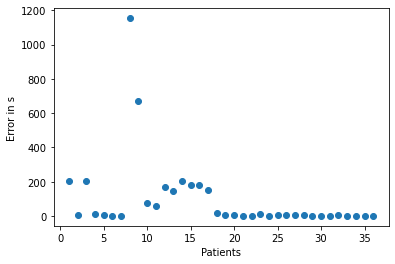

In [10]:
prediction_error = np.abs(np.asarray(onset_list_predict) - np.asarray(onset_list))

# Plotte Fehler als Scatterplot
plt.figure(1)
plt.scatter(np.arange(1, len(prediction_error)+1),prediction_error)
#plt.hlines(10, 0, len(prediction_error)+1, colors='red')
plt.ylabel('Error in s')
plt.xlabel('Patients')
plt.show()

## Seizure Classification / Detection
Beispielhaft zeigen wir hier außerdem noch ein "gelerntes" Modell zur Klassifkation eines Signals in "enthält Anfall" / "enthält keinen Anfall", das diese Trennung nur auf Basis eines einzelnen Merkmals und eines Schwellwertes vornimmt. 
Das Modell dient zur Veranschaulichung, wie man während des Trainings Parameter lernen und während der Prädiktion das Modell wieder laden kann. Außerdem wird auch der F1-Score der Klassifikation als zusätzlicher Score im Ranking angezeigt.

In [11]:
# Seizure Detection

feature = []
label = []

for i,_id in enumerate(ids):
    _fs = sampling_frequencies[i]
    _eeg_signals = data[i]
    _eeg_label = eeg_labels[i]
    label.append(_eeg_label[0])
    # Berechne Montage
    _montage, _montage_data, _is_missing = get_3montages(channels[i], _eeg_signals)
    signal_std = np.zeros(len(_montage))
    for j, signal_name in enumerate(_montage):
        # Ziehe erste Montage des EEG
        signal = _montage_data[j]
        # Wende Notch-Filter an um Netzfrequenz zu dämpfen
        signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
        # Wende Bandpassfilter zwischen 0.5Hz und 70Hz um Rauschen aus dem Signal zu filtern
        signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
        
        # In der Regel tritt während eines Anfalls eine höhere Standardabweichung im EEG auf
        signal_std[j] = np.std(signal_filter)

    # Nur der Kanal mit der maximalen Standardabweichung wird berücksichtigt
    signal_std_max = signal_std.max()
    feature.append(signal_std_max)
    

Wir können uns die Trennschärfe des Features mit den Histogrammen der Features für beide Klassen veranschaulichen.

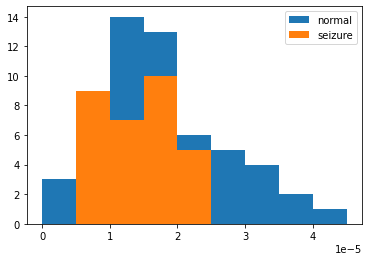

In [12]:
# Veranschaulichung der Verteilung des Features
# Definiere Feature und Label Array
X = np.array(feature)
Y = np.array(label)
# Plotte Histogramme des Features für Normal und Anfall
bins = np.arange(0,0.00005,0.000005)
plt.figure()
plt.hist(X[(Y==0)], bins=bins)
plt.hist(X[Y==1],bins=bins)
plt.legend(['normal','seizure'])

Berechne den besten Threshold per Parameter Sweep

In [13]:
best_f1 = 0
th_opt = 0
for th in np.arange(X.min(),X.max(),(X.max()-X.min())/1e5):
    pred = X>th
    TP = np.sum((pred==Y) & (Y==1))
    FP = np.sum((pred==1) & (Y==0))
    FN = np.sum((pred==0) & (Y==1))
    F1 = 2*TP/(2*TP+FP+FN)  
    if F1 >best_f1:
        th_opt = th
        best_f1 = F1

In [14]:
print('Optimaler Threshold ist', th_opt,' bei F1 auf Trainingsdaten von',best_f1)

Optimaler Threshold ist 4.925801507306836e-06  bei F1 auf Trainingsdaten von 0.5413533834586466
